In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

train = pd.read_csv('train_data.csv')

In [3]:
df_model = train.copy()
class2 = df_model[df_model['Class']==2]

df_model = df_model.append(class2)
df_model = df_model.append(class2)
df_model = df_model.append(class2)
df_model = df_model.append(class2)

##### Feature Selection

In [4]:
# drops unknown incomes as it drops performance of prediction
df_model = df_model[df_model['Income']!='Unknown']

'''Manual feature selection''' ### Terrible way to choose features, model will always predict 1
# x = df_model[['CLimit', 'Utilization', 'Income', 'Importance']]
# x = pd.get_dummies(x, columns=['Income'], drop_first=True)


'''Using VarianceThreshold and decomposition package''' ### Better than trying different features manually but still extremely biased towards predicting 1
# x = df_model.drop(columns=['Class'])
# x = pd.get_dummies(x, columns=['Gender','Education','Marital','Income', 
#                                 'KCategory', 'Group'], drop_first=True)
# sel = VarianceThreshold(threshold=0.95*(1-0.95))
# sel.fit_transform(x)

# pca = decomposition.PCA()
# pca.n_components= 4
# x = pca.fit_transform(x)


'''Selecting features via decomposition package'''
# # create dummy variables for categorical features
# x = df_model.drop(columns=['Class'])
# x = pd.get_dummies(x, columns=['Gender','Education','Marital','Income', 
#                                'KCategory', 'Group'], drop_first=True)

# # Uses decomposition.PCA package from sklearn to select the 4 best features
# pca = decomposition.PCA()
# pca.n_components= 4
# x = pca.fit_transform(x)

# y = df_model['Class']
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.26, random_state=4)

'''Selecting features using variance'''
x = df_model.drop(columns=['Class'])
y = df_model['Class']
x = pd.get_dummies(x, columns=['Gender','Education','Marital','Income', 
                               'KCategory', 'Group'], drop_first=True)
x = SelectKBest(f_classif, k=4).fit_transform(x,y)


In [5]:
x  = pd.DataFrame(x)
x

,0,1,2,3
0,3.0,4.0,67.0,0.914
1,3.0,1.0,89.0,0.679
2,4.0,2.0,111.0,0.850
3,3.0,1.0,69.0,0.568
4,6.0,4.0,44.0,0.517
...,...,...,...,...
6749,3.0,1.0,28.0,0.273
6750,4.0,3.0,36.0,0.161
6751,4.0,2.0,38.0,0.520
6752,5.0,4.0,39.0,0.696


In [6]:
X = df_model[['Relationship', 'ContactNum','TransCt', 'Ct_41']]
X ## to show that these are the features that are selected using SelectKBest()

,Relationship,ContactNum,TransCt,Ct_41
1,3,4,67,0.914
2,3,1,89,0.679
3,4,2,111,0.850
4,3,1,69,0.568
5,6,4,44,0.517
...,...,...,...,...
7590,3,1,28,0.273
7591,4,3,36,0.161
7592,4,2,38,0.520
7593,5,4,39,0.696


##### Figured out that SelectKBest chose ['Relationship', 'ContactNum','TransCt', 'Ct_41'] to be the best features based on univariate statistical tests

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.26, random_state=4)
clf = tree.DecisionTreeClassifier()
# Different hyper-parameters for the decision tree
param = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [3,6,9,12,15],
    "splitter": ["best", "random"],
    "min_samples_split": [6,8,10,12,14]
    }
# ready's the hyper-parameters for the decision tree
grid = GridSearchCV(clf, param_grid=param, cv=10)
# fits all combinations of specified hyper-parameter for decision tree
grid.fit(x_train,y_train)
print(grid.best_params_) # prints the best parameters

{'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 12, 'splitter': 'random'}


In [8]:
# creates decision tree with the best parameters for the training data
clf = tree.DecisionTreeClassifier(criterion=grid.best_params_['criterion'],max_depth=grid.best_params_['max_depth'],
                                  splitter=grid.best_params_['splitter'], min_samples_split=grid.best_params_['min_samples_split'],
                                  class_weight={1:1.58})
                                #   class_weight=grid.best_params_['class_weight'])
tree_model = clf.fit(x_train, y_train)
y_pred = tree_model.predict(x_test)
f1_score(y_test, y_pred)

0.8716755319148936

Text(0.5, 1.0, 'Confusion Matrix')

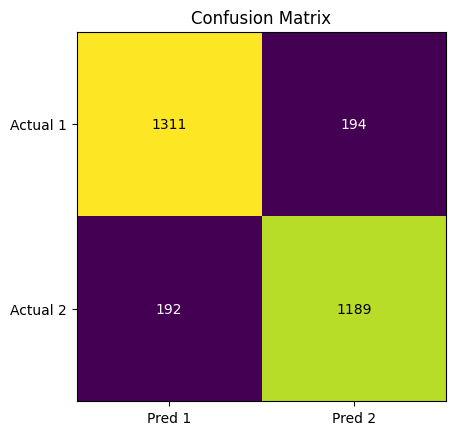

In [9]:
# Looks at predictions
cm = confusion_matrix(y_test, y_pred)
cols = ["Pred 1", "Pred 2"]
rows = ["Actual 1", "Actual 2"]

plt.imshow( cm )

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(cols)), labels=cols)
plt.yticks(np.arange(len(rows)), labels=rows)

for i in range(len(cols)):
    for j in range(len(rows)):
        if i == j:
            c = 'black'
        else:
            c = 'white'
        text = plt.text(j, i, cm[i, j], ha="center", va="center", color=c)

plt.title( 'Confusion Matrix' )

### Trying a few scalar functions to see if any significant improvements can be made

In [10]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
mm_scaler = MinMaxScaler()

std_x = std_scaler.fit_transform(X)
rob_x = rob_scaler.fit_transform(X)
mm_x = mm_scaler.fit_transform(X)

In [11]:
y = df_model['Class']

#### Standard Scaler

In [12]:
x_train, x_test, y_train, y_test = train_test_split(std_x, y, test_size=0.26, random_state=4)

In [13]:
clf = tree.DecisionTreeClassifier()
# Different hyper-parameters for the decision tree
param = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [3,6,9,12,15],
    "splitter": ["best", "random"],
    "min_samples_split": [6,8,10,12,14]
    }
# ready's the hyper-parameters for the decision tree
grid = GridSearchCV(clf, param_grid=param, cv=10)
# fits all combinations of specified hyper-parameter for decision tree
grid.fit(x_train,y_train)
print(grid.best_params_) # prints the best parameters

{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 6, 'splitter': 'best'}


In [14]:
# creates decision tree with the best parameters for the training data
clf = tree.DecisionTreeClassifier(criterion=grid.best_params_['criterion'],max_depth=grid.best_params_['max_depth'],
                                  splitter=grid.best_params_['splitter'], min_samples_split=grid.best_params_['min_samples_split']
                                  )
tree_model = clf.fit(x_train, y_train)
y_pred = tree_model.predict(x_test)
f1_score(y_test, y_pred)

0.9012517385257303

Text(0.5, 1.0, 'Confusion Matrix')

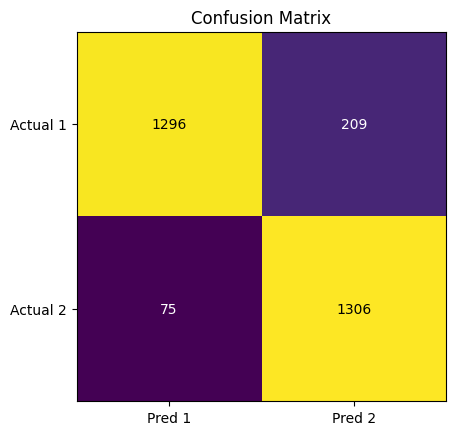

In [15]:
# Looks at predictions
cm = confusion_matrix(y_test, y_pred)
cols = ["Pred 1", "Pred 2"]
rows = ["Actual 1", "Actual 2"]

plt.imshow( cm )

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(cols)), labels=cols)
plt.yticks(np.arange(len(rows)), labels=rows)

for i in range(len(cols)):
    for j in range(len(rows)):
        if i == j:
            c = 'black'
        else:
            c = 'white'
        text = plt.text(j, i, cm[i, j], ha="center", va="center", color=c)

plt.title( 'Confusion Matrix' )

#### Robust Scaler

In [16]:
clf = tree.DecisionTreeClassifier()
# Different hyper-parameters for the decision tree
param = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [3,6,9,12,15],
    "splitter": ["best", "random"],
    "min_samples_split": [6,8,10,12,14]
    }
# ready's the hyper-parameters for the decision tree
grid = GridSearchCV(clf, param_grid=param, cv=10)
# fits all combinations of specified hyper-parameter for decision tree
grid.fit(x_train,y_train)
print(grid.best_params_) # prints the best parameters

{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 6, 'splitter': 'best'}


In [17]:
# creates decision tree with the best parameters for the training data
clf = tree.DecisionTreeClassifier(criterion=grid.best_params_['criterion'],max_depth=grid.best_params_['max_depth'],
                                  splitter=grid.best_params_['splitter'], min_samples_split=grid.best_params_['min_samples_split'],
                                  class_weight={2:0.46}
                                  )
tree_model = clf.fit(x_train, y_train)
y_pred = tree_model.predict(x_test)
f1_score(y_test, y_pred)

0.8925729442970823

Text(0.5, 1.0, 'Confusion Matrix')

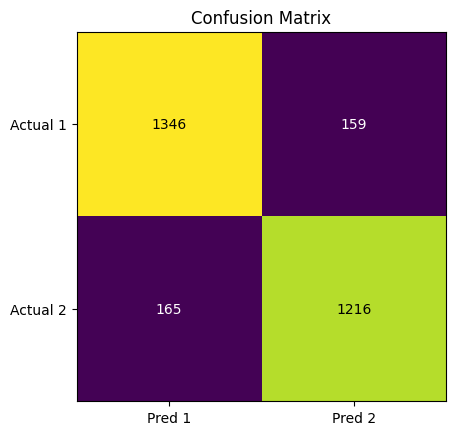

In [18]:
# Looks at predictions
cm = confusion_matrix(y_test, y_pred)
cols = ["Pred 1", "Pred 2"]
rows = ["Actual 1", "Actual 2"]

plt.imshow( cm )

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(cols)), labels=cols)
plt.yticks(np.arange(len(rows)), labels=rows)

for i in range(len(cols)):
    for j in range(len(rows)):
        if i == j:
            c = 'black'
        else:
            c = 'white'
        text = plt.text(j, i, cm[i, j], ha="center", va="center", color=c)

plt.title( 'Confusion Matrix' )

#### Effect of Scaler functions:
-> The scalar functions seem to effect the prediction bias, by altering the class_weight param I could sacrifice accuracy of predicting 1 for it to predict 2, vice versa. 
##### Conclusion
-> I will use StandardScaler function to alter test_data.csv and tweak the standard decision tree weights to try an maximize accuracy of predicting 1 when it is 1 and 2 when it is 2.

## Test Data

##### Focus on this next section of code is to balance accuracy of predicting 1 and 2 while keeping bias as low as possible

In [6]:
test = pd.read_csv('test_data.csv')

In [10]:
df_model = train.copy()
class2 = df_model[df_model['Class']==2]
# df_model = df_model.append(class2)
# df_model = df_model.append(class2)
# df_model = df_model.append(class2)
# df_model = df_model.append(class2)

AttributeError: 'DataFrame' object has no attribute 'append'

In [7]:
df_model = df_model[df_model['Income']!='Unknown']

'''Selecting features via decomposition package'''
# create dummy variables for categorical features
x = df_model.drop(columns=['Class'])
x = pd.get_dummies(x, columns=['Gender','Education','Marital','Income', 
                               'KCategory', 'Group'], drop_first=True)
y = df_model['Class']
x = SelectKBest(f_classif, k=4).fit_transform(x,y)
print(pd.DataFrame(x).head(5)) ### sanity check
x = StandardScaler().fit_transform(x)
print(pd.DataFrame(x).head(5))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)

     0    1      2      3
0  3.0  4.0   67.0  0.914
1  3.0  1.0   89.0  0.679
2  4.0  2.0  111.0  0.850
3  3.0  1.0   69.0  0.568
4  6.0  4.0   44.0  0.517
         0         1         2         3
0 -0.50903  1.394811  0.099743  0.860939
1 -0.50903 -1.316659  1.027476 -0.135041
2  0.13143 -0.412836  1.955209  0.589693
3 -0.50903 -1.316659  0.184082 -0.605483
4  1.41235  1.394811 -0.870161 -0.821631


In [22]:
clf = tree.DecisionTreeClassifier()
# Different hyper-parameters for the decision tree
param = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [3,6,9,12,15],
    "splitter": ["best", "random"],
    "min_samples_split": [6,8,10,12,14]
    }
# ready's the hyper-parameters for the decision tree
grid = GridSearchCV(clf, param_grid=param, cv=10)
# fits all combinations of specified hyper-parameter for decision tree
grid.fit(x_train,y_train)
print(grid.best_params_) # prints the best parameters

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 6, 'splitter': 'best'}


In [8]:
# creates decision tree with the best parameters for the training data
clf = tree.DecisionTreeClassifier(criterion='gini',max_depth=6,
                                  splitter='best', min_samples_split=10,
                                  class_weight={2:1.07})
tree_model = clf.fit(x_train, y_train)
y_pred = tree_model.predict(x_test)
f1_score(y_test, y_pred)

0.9432440218957073

Text(0.5, 1.0, 'Confusion Matrix')

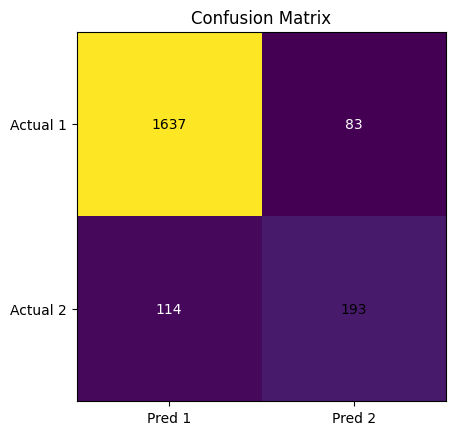

In [9]:
# Looks at predictions
cm = confusion_matrix(y_test, y_pred)
cols = ["Pred 1", "Pred 2"]
rows = ["Actual 1", "Actual 2"]

plt.imshow( cm )

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(cols)), labels=cols)
plt.yticks(np.arange(len(rows)), labels=rows)

for i in range(len(cols)):
    for j in range(len(rows)):
        if i == j:
            c = 'black'
        else:
            c = 'white'
        text = plt.text(j, i, cm[i, j], ha="center", va="center", color=c)

plt.title( 'Confusion Matrix' )

### Apply to test_data.csv

In [10]:
# test = test[test['Income']!='Unknown'] # drops unknown incomes as it drops performance of prediction

x = test[['Relationship', 'ContactNum','TransCt', 'Ct_41']]
# use tree_model to predict y
y_pred = tree_model.predict(x)

/Users/ericwang/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [26]:
np.savetxt('/Users/ericwang/Desktop/ECON_148/Midterm/test_result2.csv.csv',y_pred, delimiter=',')

In [11]:
len(test)

2532

In [12]:
len(y_pred)

2532